# Add brain internal features

In [1]:
import os
if 'notebooks' in os.getcwd(): os.chdir('../..')  # change to main directory
print('Working directory:', os.getcwd() )

Working directory: /scratch/snx3000/bp000429/adrian_sensorium


In [2]:
import glob

import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
from tqdm import tqdm

In [3]:
%matplotlib inline

In [4]:
# folder in which the combined results of the model fit were saved
res_folder = 'notebooks/my_results/'
save_folder = 'notebooks/data/'

model_behav = 'res_v1_allBehavior.npy'
model_stim = 'res_v1_onlyShifter.npy'

data_behav = np.load( os.path.join(res_folder, model_behav), allow_pickle=True).item()
data_stim = np.load( os.path.join(res_folder, model_stim), allow_pickle=True).item()
keys = list( data_stim.keys() )
keys

['27204-5-13',
 '23343-5-17',
 '23964-4-22',
 '23656-14-22',
 '22846-10-16',
 '21067-10-18']

# Calculate global gain factor

### Calculate gain on training and validation data

In [5]:
def calculate_stimulus_gain(data_stim, key, thres=0.1, with_test=False,
                           by_mean=False):
    """ Extract average stimulus gain by comparing image-only model with recorded data
    
    Adrian 2022-09-30 """
    
    trial_type = data_stim[key]['trial_type']
    stim_mat = data_stim[key]['output']
    true_mat = data_stim[key]['target']

    nr_trials = true_mat.shape[0]
    nr_neurons = true_mat.shape[1]

    # gain including test set if available
    gain_all = np.zeros( (nr_trials, nr_neurons) ) * np.nan

    for n in range(nr_neurons):
        non_zero = true_mat[:,n] > thres
        gain_all[non_zero, n] = 1 - stim_mat[non_zero,n] / true_mat[non_zero,n]
    
    if by_mean:
        # compare mean response to average response
        avg_gain_all = np.mean(true_mat, axis=1) / np.mean(true_mat) - 1
    else:
        avg_gain_all = np.nanmean(gain_all, axis=1)

    # remove trials that are in test data
    avg_gain_train = np.copy( avg_gain_all )
    avg_gain_train[trial_type > 1] = np.nan
    
    if with_test == False:    
        return avg_gain_train
    else:
        return avg_gain_train, avg_gain_all

### Fit piecewise gaussian process to the data

In [6]:
def fit_piecewise_gaussian_process(signal, std=0.2, length_scale=5, nr_splits=10):
    """ Fit Gaussian process to interpolate nans in the signal
    Adrian 2022-09-30 """
    
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF

    interp_signal = np.zeros( len(signal) ) * np.nan
    index_signal = np.arange( len(signal) )

    nr_per_split = int(len(signal) / nr_splits) + 1

    for split in range(nr_splits):
        start = nr_per_split*split
        end = nr_per_split*(split+1)
        part_index = index_signal[start:end]

        # select data to fit gaussian process
        x_train = index_signal[np.max((0,start-50)):end+50]
        y_train = signal[np.max((0,start-50)):end+50]

        # remove nans (test data) from training data
        x_train = x_train[~np.isnan(y_train)]
        y_train = y_train[~np.isnan(y_train)]


        # fit Gaussian process
        kernel = 1 * RBF(length_scale=length_scale, length_scale_bounds='fixed')
        gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=std**2, n_restarts_optimizer=2)
        gaussian_process.fit(x_train.reshape(-1, 1), y_train)

        # evaluate fit at all indicies
        y_result = gaussian_process.predict(part_index.reshape(-1, 1))
        interp_signal[part_index] = y_result

    return interp_signal

100%|██████████| 6/6 [01:12<00:00, 12.10s/it]


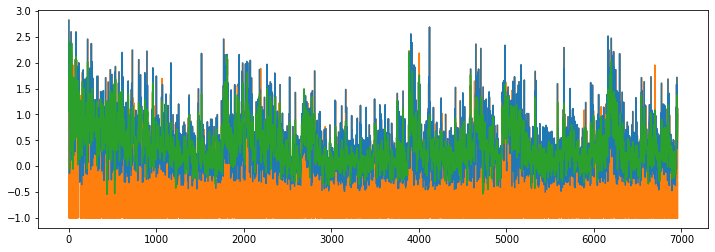

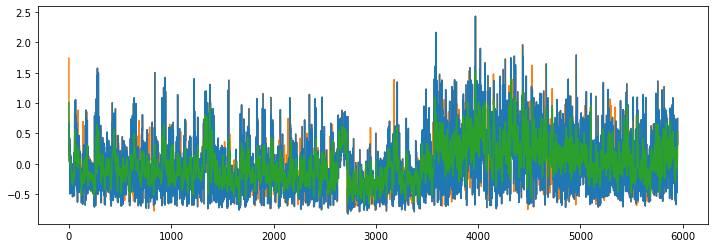

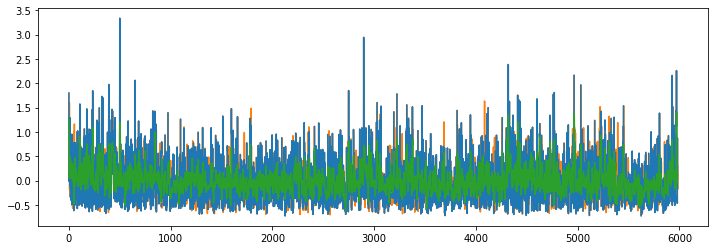

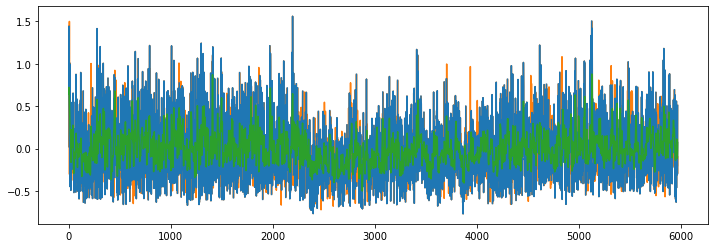

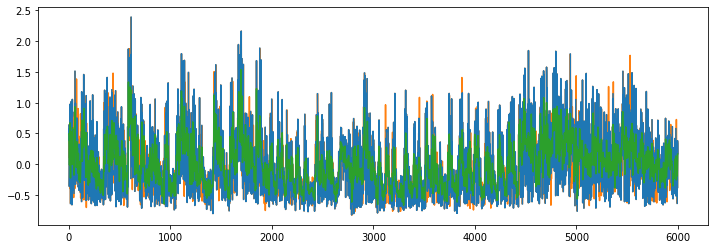

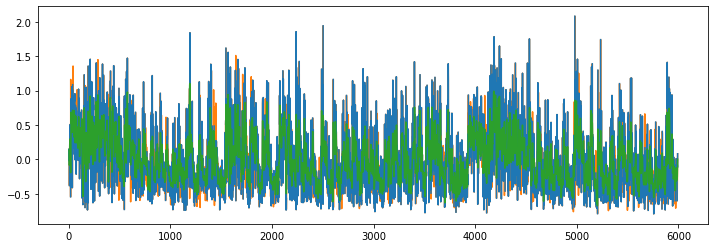

In [7]:
# new variant: calculate gain based on average response
gains = dict()

for key in tqdm(keys):
    
    gain_train, gain_all = calculate_stimulus_gain(data_stim, key, thres=0.1,
                                                   with_test=True, by_mean=True)
    gain_interp = fit_piecewise_gaussian_process(signal=gain_train, std=0.2, length_scale=3, nr_splits=10)
    gains[key] = gain_interp
    
    plt.figure(figsize=(12,4))
    plt.plot(gain_all, color='C1', label='Test Data')
    plt.plot(gain_train, color='C0', label='Train')
    plt.plot(gain_interp, label='Interpolation', color='C2')

### Save gains in order like training data

In [8]:
for key in keys:
    gain = gains[key]

    # these are the trial_ids sorted by time, like all other variables
    trial_id = data_stim[key]['trial_id']

    reordered_gain = np.zeros( len(gain) )
    for i, id_ in enumerate(trial_id):
        reordered_gain[id_] = gain[i]

    # add dimension for dataloader to work
    reordered_gain = np.expand_dims(reordered_gain, axis=1)
    
    # hardcoded transformation of data key to folder name
    before = 'static'
    after = '-GrayImageNet-94c6ff995dac583098847cfecd43e7b6'
    merged_folder = os.path.join( save_folder, before+key+after, 'merged_data' )

    np.save( os.path.join(merged_folder, 'meangain.npy'), reordered_gain)

(4000.0, 4200.0)

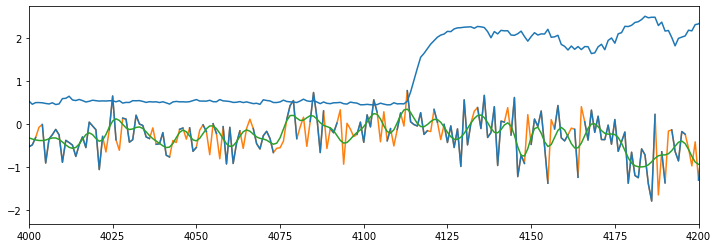

In [13]:
plt.figure(figsize=(12,4))
plt.plot(gain_all, color='C1', label='Test Data')
plt.plot(gain_train, color='C0', label='Train')
plt.plot(gain_interp, label='Interpolation', color='C2')

plt.plot( data_stim[key]['pupil']/30 )
plt.xlim(4000,4200)

  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_31466/1121520882.py:20: RuntimeWarning: Mean of empty slice
  avg_gain_all = np.nanmean(gain_all, axis=1)
100%|██████████| 6/6 [01:45<00:00, 17.65s/it]


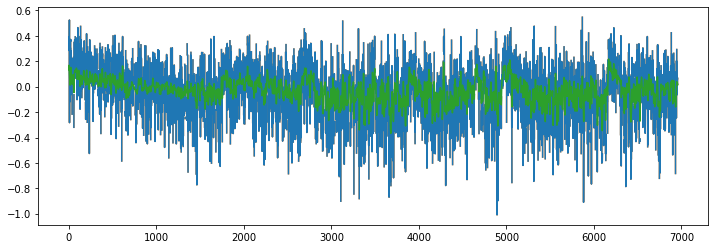

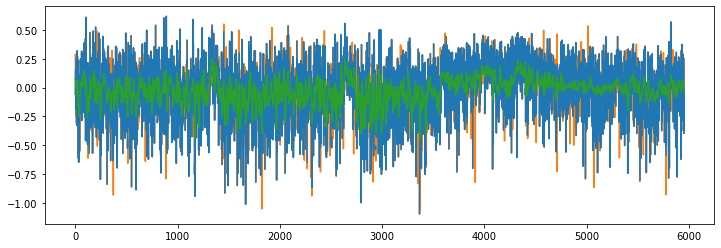

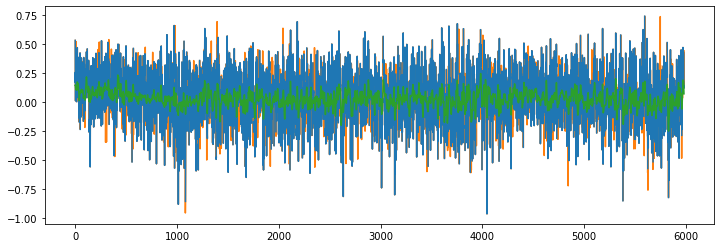

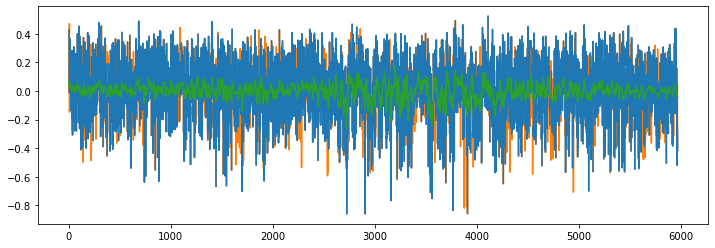

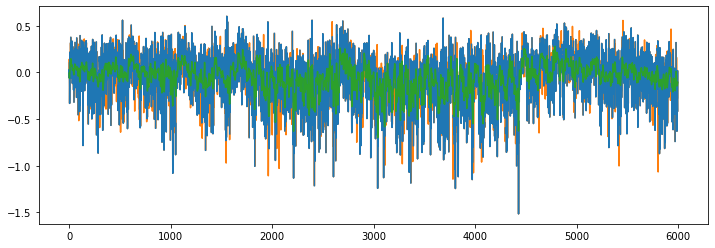

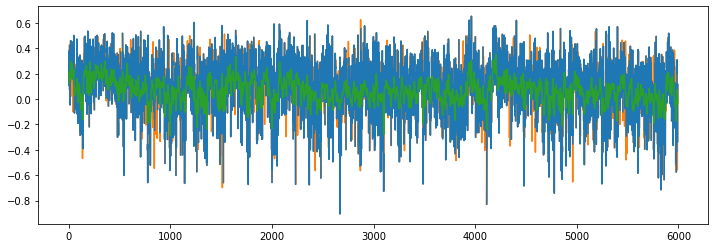

In [7]:
gains = dict()

for key in tqdm(keys):
    
    gain_train, gain_all = calculate_stimulus_gain(data_stim, key, thres=0.1, with_test=True)
    gain_interp = fit_piecewise_gaussian_process(signal=gain_train, std=0.2, length_scale=3, nr_splits=10)
    gains[key] = gain_interp
    
    plt.figure(figsize=(12,4))
    plt.plot(gain_all, color='C1', label='Test Data')
    plt.plot(gain_train, color='C0', label='Train')
    plt.plot(gain_interp, label='Interpolation', color='C2')

### Save gains in order like training data

In [8]:
for key in keys:
    gain = gains[key]

    # these are the trial_ids sorted by time, like all other variables
    trial_id = data_stim[key]['trial_id']

    reordered_gain = np.zeros( len(gain) )
    for i, id_ in enumerate(trial_id):
        reordered_gain[id_] = gain[i]

    # add dimension for dataloader to work
    reordered_gain = np.expand_dims(reordered_gain, axis=1)
    
    # hardcoded transformation of data key to folder name
    before = 'static'
    after = '-GrayImageNet-94c6ff995dac583098847cfecd43e7b6'
    merged_folder = os.path.join( save_folder, before+key+after, 'merged_data' )

    np.save( os.path.join(merged_folder, 'gain.npy'), reordered_gain)

### Test to find best smoothing parameter

In [9]:
# ls = np.arange(1,6)
# errors = list()
# for l_scale in ls:
#     interp_signal = fit_piecewise_gaussian_process(avg_gain_train, std=0.2, length_scale=l_scale, nr_splits=10)
#     error = np.sqrt( np.sum( np.square(interp_signal[test_select]-avg_gain_all[test_select])))
#     errors.append(error)

In [10]:
# plt.figure()
# plt.plot(ls, errors)

### Create recurrent signals

In [11]:
def create_recurrent_regressor(key, lag, data_stim):
    """ Create causal recurrent regressor which only uses training data points
    Adrian 2022-09-30 """

    inds = np.arange(-lag,0)   # e.g. [-2,-1] for lag 2

    trial_type = data_stim[key]['trial_type']
    true = data_stim[key]['target']   # (nr_trials, nr_neurons)
    
    nr_trials = true.shape[0]
    nr_neurons = true.shape[1]

    # zero padding at end to map negative indicies in inds to 0
    true_padded = np.concatenate( (true, np.zeros((lag+1, nr_neurons))) )
    history = np.zeros( (nr_trials, nr_neurons) )

    for i in range( len(trial_type) ):
        # add entry to hist vector
        history[i] = np.mean( true_padded[inds,:], axis=0 )

        # shift hist vector for next entry
        if trial_type[i] < 2:
            # data for this point is available => shifts inds
            inds[0:lag-1] = inds[1:]
            inds[-1] = i
        else:
            # otherwise do nothing, because true value is not available => keep last ones
            pass
    return history
        
def get_multiple_lags(key, lags, data_stim):
    """ Create 3d matrix with different history filters
    Adrian 2022-09-30 """
    
    true = data_stim[key]['target']   # (nr_trials, nr_neurons)
    nr_trials = true.shape[0]
    nr_neurons = true.shape[1]
    
    history_mat = np.zeros( (nr_trials, nr_neurons, len(lags)) )
    
    for i, lag in enumerate(lags):
        history_mat[:,:,i] = create_recurrent_regressor(key, lag, data_stim=data_stim)
        
    return history_mat

100%|██████████| 6/6 [01:07<00:00, 11.30s/it]


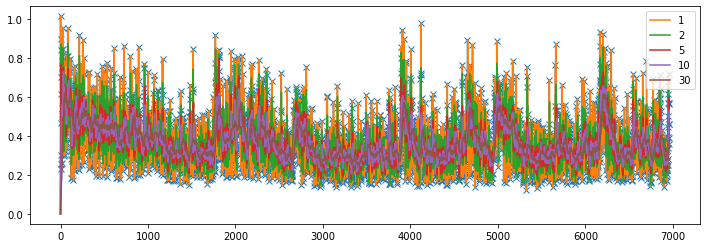

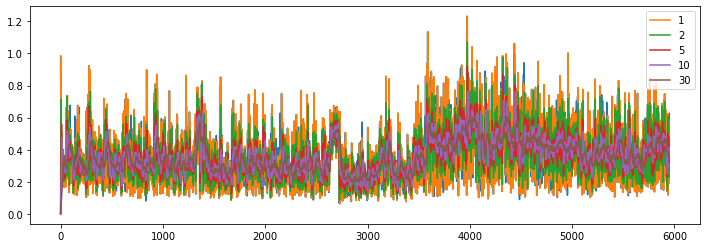

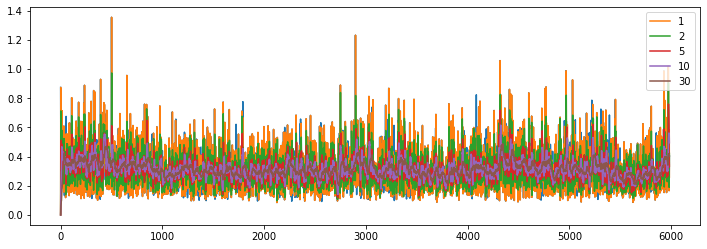

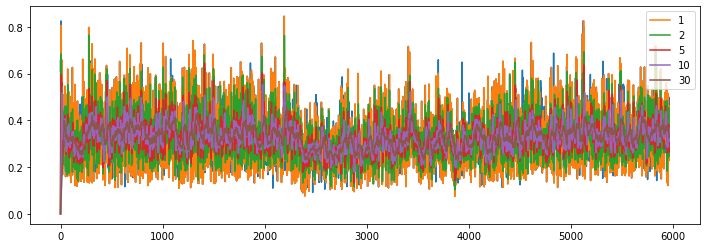

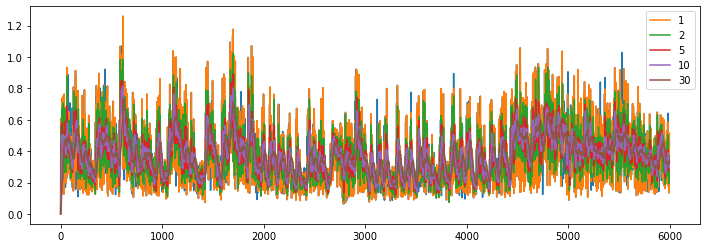

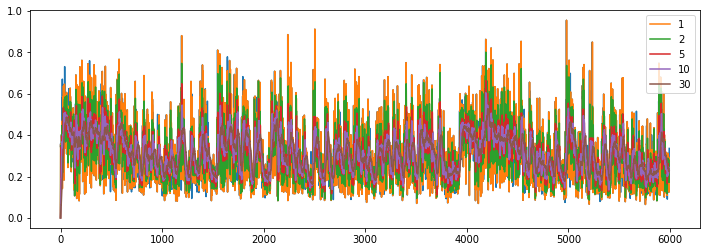

In [12]:
lags = [1,2,5,10,30]
history = dict()

for key in tqdm(keys):
    # get history values with different lags
    history_mat = get_multiple_lags(key, lags, data_stim)
    
    # for sanity check of data, plot average with history
    plt.figure(figsize=(12,4))
    true = np.mean( data_stim[key]['target'], axis=1 )
    if key == '27204-5-13':  # competition dataset with many 0s
        true[true==0] = np.nan
        plt.plot( true, 'x-' )
    else:
        plt.plot( true )
        
    for i, lag in enumerate(lags):
        plt.plot(np.mean(history_mat[:,:,i], axis=1), label=str(lag))
    plt.legend(loc='upper right')

    # these are the trial_ids sorted by time, like all other variables
    trial_id = data_stim[key]['trial_id']
    
    # shape: (nr_trials, nr_neurons, nr_lags)
    reordered_history = np.zeros_like( history_mat )
    for i, id_ in enumerate(trial_id):
        reordered_history[id_] = history_mat[i]
        
    # save matrix
    # hardcoded transformation of data key to folder name
    before = 'static'
    after = '-GrayImageNet-94c6ff995dac583098847cfecd43e7b6'
    merged_folder = os.path.join( save_folder, before+key+after, 'merged_data' )

    np.save( os.path.join(merged_folder, 'history.npy'), reordered_history)
    

(1000.0, 1050.0)

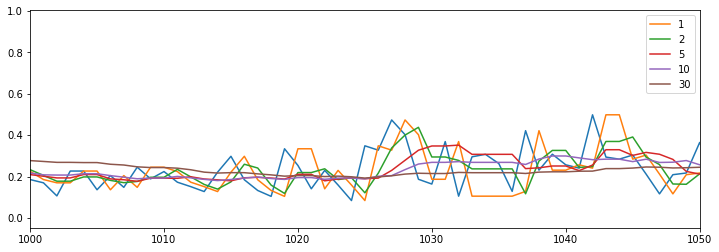

In [14]:
plt.figure(figsize=(12,4))
true = np.mean( data_stim[key]['target'], axis=1 )
plt.plot( true )

for i, lag in enumerate(lags):
    plt.plot(np.mean(history_mat[:,:,i], axis=1), label=str(lag))
plt.legend(loc='upper right')
plt.xlim(1000,1050)

# Calculate behavior state
The stimulus changes on every datapoint, but the behavioral state can be more longlasting.

To extract the dimensions of the behavioral state, independent of the stimulus, I am therefore calculating the reduced-rank regression between the neural activity at time t and t+1. This dimension should by experimental design not contain any stimulus information, but only information which is shared across time and is therefore stimulus independent.

In [5]:
def extract_response_t_and_t_plus_one(key, data_stim, residual=False):
    """ Get matrix with correct pairs of t and t+1
    Adrian 2022-10-03 """

    trial_type = data_stim[key]['trial_type']
    true = data_stim[key]['target']   # (nr_trials, nr_neurons)
    if residual:
        true = data_stim[key]['target'] - data_stim[key]['output']
    
    t_list = list()
    t_one_list = list()
    
    # find pairs of t and t+1 that are both in the training data
    for i in range( 1, len(trial_type) ):
        if (trial_type[i-1]<2) and (trial_type[i-1]<2):
            t_list.append(i-1)
            t_one_list.append(i)
    
    true_t = true[ t_list, : ]
    true_t_one = true[ t_one_list, : ]
    
    return true_t, true_t_one

In [6]:
def rrvar(data_t, data_t_one, rank, maxiter = 100):
    """Reduced-rank VAR algorithm to predict next timepoint in matrix
    
    data_t: 2d matrix (nr_trials, nr_features)
    
    Function based on code by Xinyu Chen
    https://towardsdatascience.com/reduced-rank-vector-autoregressive-model-for-high-dimensional-time-series-forecasting-bdd17df6c5ab
    """
    from tqdm import tqdm
    
    N = data_t.shape[1]   # number of features
    X1 = data_t.T  # change to (nr_features, nr_trials)
    X2 = data_t_one.T
    
    V = np.random.randn(rank, N)
    for it in tqdm(range(maxiter)):
        W = X2 @ np.linalg.pinv(V @ X1)
        V = np.linalg.pinv(W) @ X2 @ np.linalg.pinv(X1)
    
    return W, V

In [7]:
def create_recurrent_regressor(key, lag, data_stim):
    """ Create causal recurrent regressor which only uses training data points
    Adrian 2022-09-30 """

    inds = np.arange(-lag,0)   # e.g. [-2,-1] for lag 2

    trial_type = data_stim[key]['trial_type']
    true = data_stim[key]['target']   # (nr_trials, nr_neurons)
    
    nr_trials = true.shape[0]
    nr_neurons = true.shape[1]

    # zero padding at end to map negative indicies in inds to 0
    true_padded = np.concatenate( (true, np.zeros((lag+1, nr_neurons))) )
    history = np.zeros( (nr_trials, nr_neurons) )

    for i in range( len(trial_type) ):
        # add entry to hist vector
        history[i] = np.mean( true_padded[inds,:], axis=0 )

        # shift hist vector for next entry
        if trial_type[i] < 2:
            # data for this point is available => shifts inds
            inds[0:lag-1] = inds[1:]
            inds[-1] = i
        else:
            # otherwise do nothing, because true value is not available => keep last ones
            pass
    return history

100%|██████████| 100/100 [00:38<00:00,  2.57it/s]


(6959, 10)


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


(5951, 10)


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


(5983, 10)


100%|██████████| 100/100 [00:38<00:00,  2.62it/s]


(5966, 10)


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]
/users/bp000429/.local/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


(5997, 10)


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]
/users/bp000429/.local/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


(5994, 10)


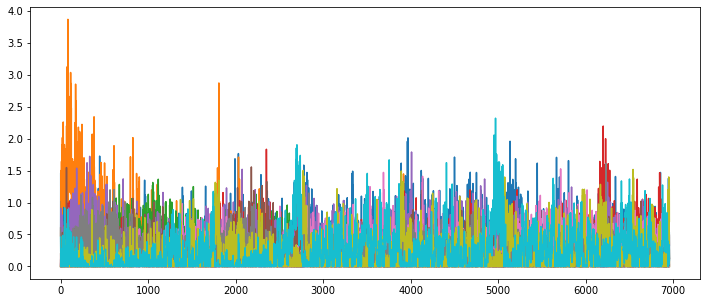

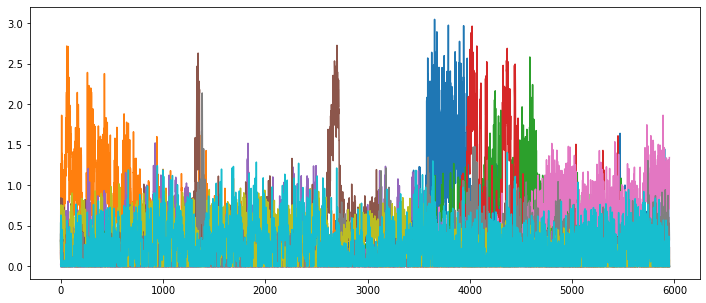

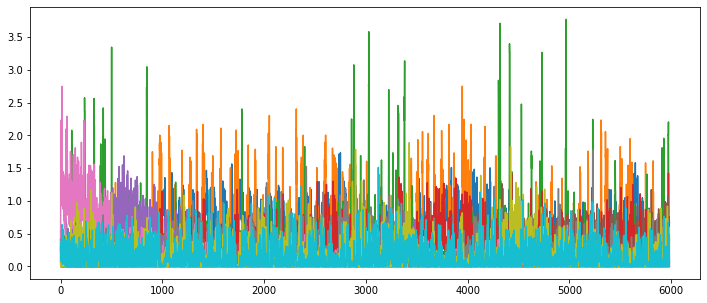

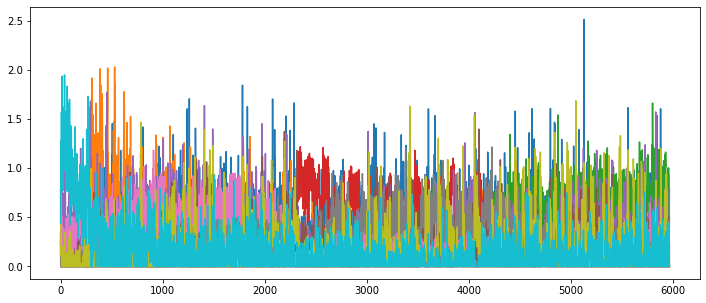

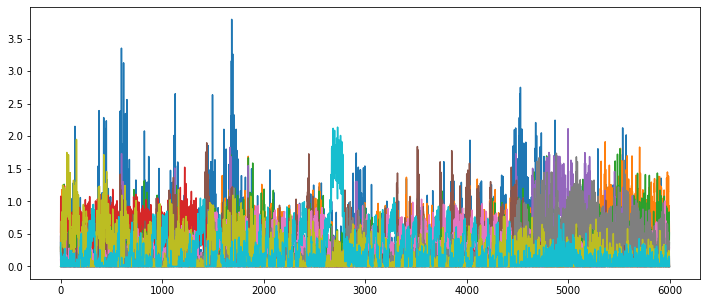

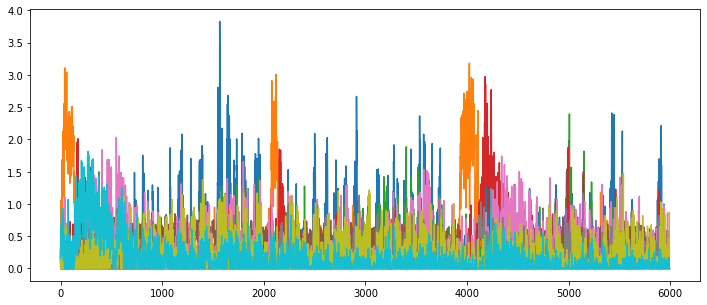

In [10]:
for key in keys:
    # get trial pairs that are in the training dataset (nr_trial, neurons)
    data_t, data_t_one = extract_response_t_and_t_plus_one(key, data_stim, residual=False)
    
    data_t = np.sqrt( data_t + 1e-6 )  # make sure positive values only
    data_t_one = np.sqrt( data_t_one + 1e-6 )
    
    # first PCA to reduce runtime of reduced rank regression
    from sklearn.decomposition import PCA
    pca = PCA(n_components=500)
    pca.fit(data_t)
    t_pca = pca.transform(data_t)    # (trials, n_components)
    t_one_pca = pca.transform(data_t_one)
    
    # calculate embedding matricies for reduced-rank autoregression
    # extract projection that helps to predict next timepoint
    W, V = rrvar(t_pca, t_one_pca, rank=20)
    rr_embedding = V @ t_pca.T  # output: (rank, nr_trials_train)
    
    # now project back into neuron space
    restored = pca.inverse_transform( (W @ rr_embedding).T )
    restored[ restored < 0 ] = 0  # make positive
    # use non-negative matrix factorization to get sparser+positive values
    from sklearn.decomposition import NMF
    nmf = NMF(n_components=10, init='random', random_state=674, max_iter=1000)
    nmf.fit(restored)
    
    # now pass the data for each trial (which can contain repeats) through same embedding
    history_lag_one = create_recurrent_regressor(key, lag=1, data_stim=data_stim)
    
    rr_embedding = V @ pca.transform( history_lag_one ).T  # output: (rank, nr_trials)
    # now project back into neuron space
    restored = pca.inverse_transform( (W @ rr_embedding).T )
    restored[ restored < 0 ] = 0  # make positive
    nmf_embedding = nmf.transform( restored )

    # plot saved regressors
    plt.figure(figsize=(12,5))
    _ = plt.plot(nmf_embedding)
    
    # these are the trial_ids sorted by time, like all other variables
    trial_id = data_stim[key]['trial_id']

    reordered_nmf = np.zeros_like( nmf_embedding )
    print(reordered_nmf.shape)
    
    for i, id_ in enumerate(trial_id):
        reordered_nmf[id_] = nmf_embedding[i]

    # add dimension for dataloader to work
    # reordered_gain = np.expand_dims(reordered_gain, axis=1)
    
    # save matrix
    # hardcoded transformation of data key to folder name
    before = 'static'
    after = '-GrayImageNet-94c6ff995dac583098847cfecd43e7b6'
    merged_folder = os.path.join( save_folder, before+key+after, 'merged_data' )

    np.save( os.path.join(merged_folder, 'state.npy'), reordered_nmf )   

(1400.0, 1900.0)

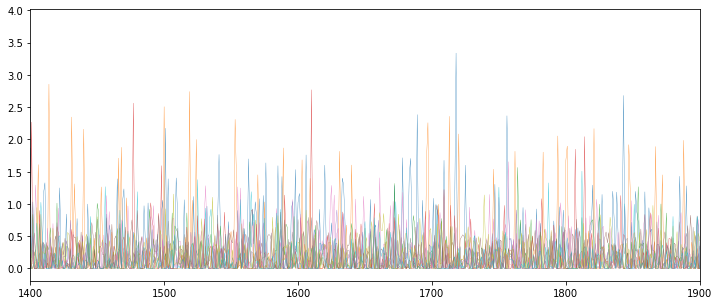

In [14]:
plt.figure(figsize=(12,5))
_ = plt.plot(nmf_embedding[:,0:], lw=0.3)
plt.xlim(1400,1900)

In [30]:
pca2 = PCA(n_components=10)
pca2.fit(embedding_white)
emb_pca = pca2.transform( embedding_white )

In [31]:
emb_pca.shape

(5983, 10)

In [32]:
np.corrcoef(emb_pca, rowvar=False)

array([[ 1.00000000e+00,  5.14980282e-16,  6.22234536e-16,
         5.56166596e-16, -6.90102930e-17,  5.38430940e-16,
         7.11500822e-16, -2.93892115e-16,  7.11960244e-16,
        -6.77658956e-16],
       [ 5.14980282e-16,  1.00000000e+00, -3.07320155e-16,
         2.54790481e-16, -3.57609823e-16,  7.26474866e-16,
         1.78415998e-16, -8.71909054e-16,  4.23260967e-16,
        -1.89228039e-15],
       [ 6.22234536e-16, -3.07320155e-16,  1.00000000e+00,
         9.17381213e-16, -8.73859810e-16, -6.53732050e-16,
         7.74959488e-17, -1.46514412e-15,  1.59332377e-15,
        -1.57132180e-16],
       [ 5.56166596e-16,  2.54790481e-16,  9.17381213e-16,
         1.00000000e+00, -1.37367459e-15, -1.79811805e-16,
        -6.43183014e-16, -1.15824111e-15,  1.71597209e-15,
        -8.32052750e-16],
       [-6.90102930e-17, -3.57609823e-16, -8.73859810e-16,
        -1.37367459e-15,  1.00000000e+00,  1.34648426e-15,
        -3.65930450e-16, -6.19261142e-17, -1.93452587e-15,
         1.

In [28]:
embedding_white.shape

(5983, 10)